In [ ]:
! nvidia-smi

Wed Oct  7 11:06:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import time;
start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_Inp_Dataset_192.zip' -d 'Data/'
print (time.time() - start)

223.88731217384338


In [ ]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/MonoDepth_GT_Dataset_192.zip' -d 'Data/Dataset/depth_'
print (time.time() - start)

78.97969555854797


In [ ]:
import time;

start = time.time()
!unzip -q 'gdrive/My Drive/Pull-0-Depth/bg_192.zip' -d 'Data/Dataset/bg_'
print (time.time() - start)

1.2111313343048096


In [ ]:
import os

list_m = os.listdir('Data/Dataset/mask_/mask') # dir is your directory path
list_f = os.listdir('Data/Dataset/fg_bg_/fg_bg') # dir is your directory path
list_d = os.listdir('Data/Dataset/depth_/depth') # dir is your directory path
list_b_temp = os.listdir('Data/Dataset/bg_/bg_192') # dir is your directory path

list_f.sort()
list_m.sort()
list_d.sort()
list_b_temp.sort()

list_b = []
for bg in list_b_temp:
    list_b += [bg]*4000

print('No. of fg_bg Images: ', len(list_f))
print('No. of mask Images: ', len(list_m))
print('No. of depth Images: ', len(list_d))
print('No. of backround Images: ', len(list_b))

No. of fg_bg Images:  400000
No. of mask Images:  400000
No. of depth Images:  400000
No. of backround Images:  400000


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time

In [ ]:
# Shuffling the Dataset
import random

for _ in range(5):
    seed = random.random()
    def rand_num():
        return seed
    random.shuffle(list_f, rand_num)
    random.shuffle(list_b, rand_num)

#Testing if Randomizing worked
print(list_f[351275])
print(list_b[351275])

bg192_22_fg3155.jpg
bg192_22.jpg


In [ ]:
#Creating Split of Data for Training and Testing of 70:30
train_split = int(len(list_f)*0.9975)
train_data = list_f[0:train_split]
test_data = list_f[train_split:]
print(len(train_data), len(test_data))

399000 1000


In [ ]:
from Data import DepMaskDataset
train_dataset = DepMaskDataset(train_data)
test_dataset = DepMaskDataset(test_data)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
data = next(iter(train_loader))
print(type(data))
print(len(data))

<class 'dict'>
4


In [ ]:
print(len(train_loader)) # Number of Train Batches
print(len(test_loader)) # Number of Test Batches 

6235
16


In [ ]:
print('Number of fg_bg Images in one batch: ', data['fgbg'].shape)
print('Number of bg Images in one batch: ', data['bg'].shape)
print('Number of mask Images in one batch: ', data['mask'].shape)
print('Number of depth Images in one batch: ', data['depth'].shape)

Number of fg_bg Images in one batch:  torch.Size([64, 3, 192, 192])
Number of bg Images in one batch:  torch.Size([64, 3, 192, 192])
Number of mask Images in one batch:  torch.Size([64, 1, 192, 192])
Number of depth Images in one batch:  torch.Size([64, 1, 192, 192])


In [ ]:
from UNet import UNet
from loss import BCEDiceLoss, RMSELoss, rmse, miou
import torch.optim as optim
from tqdm import tqdm
import gc

In [ ]:
model = UNet(6).to('cuda')
optimizer = optim.Adam(model.parameters())

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/Pull-0-Depth/model_weights/weights_ep5.pth') #Contunuing From 5th Epoch
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
from torchsummary import summary
summary(model, (6,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           3,456
       BatchNorm2d-2         [-1, 64, 192, 192]             128
              ReLU-3         [-1, 64, 192, 192]               0
            Conv2d-4         [-1, 64, 192, 192]          36,864
       BatchNorm2d-5         [-1, 64, 192, 192]             128
              ReLU-6         [-1, 64, 192, 192]               0
        DoubleConv-7  [[-1, 64, 192, 192], [-1, 64, 192, 192]]               0
         MaxPool2d-8           [-1, 64, 96, 96]               0
            Conv2d-9          [-1, 128, 96, 96]          73,728
      BatchNorm2d-10          [-1, 128, 96, 96]             256
             ReLU-11          [-1, 128, 96, 96]               0
           Conv2d-12          [-1, 128, 96, 96]         147,456
      BatchNorm2d-13          [-1, 128, 96, 96]             256
             ReLU-14    

In [ ]:
from train import train
from test import test

In [ ]:
start_process = time.time()
for i in range(1,6):
    epoch_time = time.time()
    train(train_loader, model, optimizer)
    print(f'********* EPOCH {i+1} TIME: {time.time()-epoch_time} seconds')
    print('******************************************************************************************************************')
torch.cuda.empty_cache()
fgbg, bg, mask_gt, depth_gt, mask_pred, depth_pred = test(test_loader, model, optimizer)
print('Total Time: ', time.time() - start_process)

In [ ]:
start_process = time.time()
torch.cuda.empty_cache()
fgbg, bg, mask_gt, depth_gt, mask_pred, depth_pred = test(test_loader, model, optimizer)
print('Total Time: ', time.time() - start_process)

100%|██████████| 16/16 [00:05<00:00,  2.89it/s]



Load Time:  4.478017568588257
Prediciton Time:  0.09906983375549316
Loss Time:  0.021110057830810547
Total Time for One Batch:  5.541755199432373
********************* LOSSES ****************************
Segmentation Loss:  1.1004478931427002
Depth Loss:  0.06946947425603867
Total Loss:  1.169917345046997
mean IOU:  0.27077096700668335
mean RMSE:  0.06946947425603867
********************* ****** ****************************
Total Time:  5.831911325454712


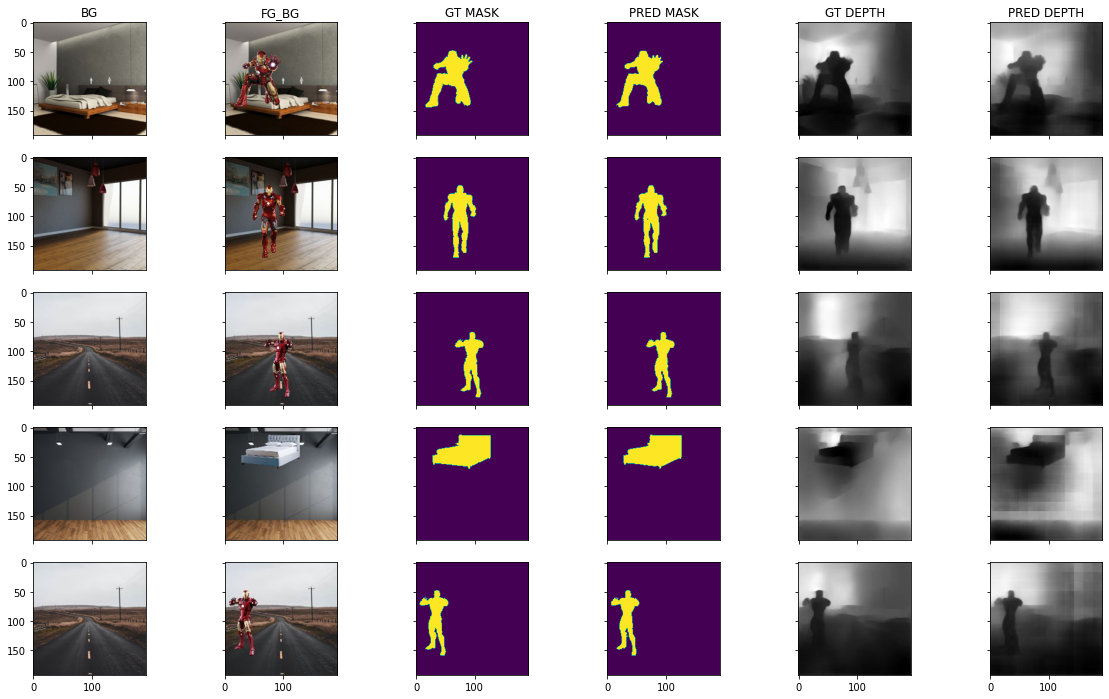

In [ ]:
from plot import plot
plot(fgbg, bg, mask_gt, mask_pred, depth_gt, depth_pred)

In [ ]:
torch.save({
            'epoch': 5,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/gdrive/My Drive/Pull-0-Depth/weights_ep5.pth')

### Testing using other User's Data

In [ ]:
#Using Totally External Data from Other Users for Testing.

import os

list_m = os.listdir('gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetMask')
list_f = os.listdir('gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetFGBG')
list_d = os.listdir('gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetDepth')
list_b = os.listdir('gdrive/My Drive/Pull-0-Depth/GaneshDataset/Images/background')

list_f.sort()
list_m.sort()
list_d.sort()
list_b.sort()


print('No. of fg_bg Images: ', len(list_f))
print('No. of mask Images: ', len(list_m))
print('No. of depth Images: ', len(list_d))
print('No. of backround Images: ', len(list_b))

No. of fg_bg Images:  4000
No. of mask Images:  4000
No. of depth Images:  4000
No. of backround Images:  100


In [ ]:
list_f[10]

'fg_bg1007.jpg'

In [ ]:
f = open("file_name.txt", "a")
for line in list_f:
    f.write(f"{line} 0\n")
f.close()

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import time


class ExtDepMaskDataset(Dataset):
    def __init__(self, file_list):

        self.to_tensor = transforms.ToTensor()
        self.fg_norm = transforms.Normalize(mean=[0.56414794921875, 0.5432481169700623, 0.5214933753013611],
                                            std=[0.208669513463974, 0.213966503739357, 0.2230370044708252])
        self.bg_norm = transforms.Normalize(mean=[0.5810659527778625, 0.5633341670036316, 0.5403051972389221],
                                            std=[0.18558748066425323, 0.19134603440761566, 0.20390349626541138])
        self.mask_norm = transforms.Normalize(mean=0.09639497846364975,
                                              std=0.2823259234428406)
        self.depth_norm = transforms.Normalize(mean=0.40525129437446594,
                                               std=0.24363896250724792)
        self.file_name_list = file_list
        self.fgbg = 'gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetFGBG/'
        self.bg = 'gdrive/My Drive/Pull-0-Depth/GaneshDataset/Images/background/1.jpg'
        self.mask = 'gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetMask/'
        self.depth = 'gdrive/My Drive/Pull-0-Depth/ExternalDataset/GaneshDatasetDepth/'
        self.len = len(self.file_name_list)

    def __getitem__(self, index):
        # stuff

        fg = Image.open(self.fgbg+self.file_name_list[index]).convert('RGB').resize((192,192))
        bg = Image.open(self.bg).convert('RGB').resize((192,192))
        mask = Image.open(self.mask+'fg_bg_masks'+self.file_name_list[index][5:]).convert('L')
        mask_arr = np.array(mask)
        mask_arr[mask_arr >= 150] = 255
        mask_arr[mask_arr < 150] = 0
        mask = Image.fromarray(mask_arr).convert('L').resize((192,192))
        depth = Image.open(self.depth+'depth_fg_bg'+self.file_name_list[index][5:]).convert('L').resize((192,192))

        fg = self.to_tensor(fg)
        bg = self.to_tensor(bg)
        mask = self.to_tensor(mask)
        depth = self.to_tensor(depth)

        fg = self.fg_norm(fg)
        bg = self.bg_norm(bg)
        mask = self.mask_norm(mask)
        depth = self.depth_norm(depth)

        return {'fgbg': fg, 'bg': bg, 'mask': mask, 'depth': depth}

    def __len__(self):
        return self.len  # of how many data(images) you have

In [ ]:
ext_test_dataset = ExtDepMaskDataset(list_f[:100])
ext_test_loader = DataLoader(ext_test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [25]:
start_process = time.time()
fgbg, bg, mask_gt, mask_pred, depth_gt, depth_pred = test(ext_test_loader, model, optimizer)
print('Total Time: ', time.time() - start_process)

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



Load Time:  0.3062021732330322
Prediciton Time:  0.019746780395507812
Loss Time:  0.0031044483184814453
Total Time for One Batch:  1.3573949337005615
********************* LOSSES ****************************
Segmentation Loss:  1.1427704095840454
Depth Loss:  0.16804903745651245
Total Loss:  1.310819387435913
mean IOU:  0.2590329945087433
mean RMSE:  0.16804903745651245
********************* ****** ****************************
Total Time:  1.6323132514953613


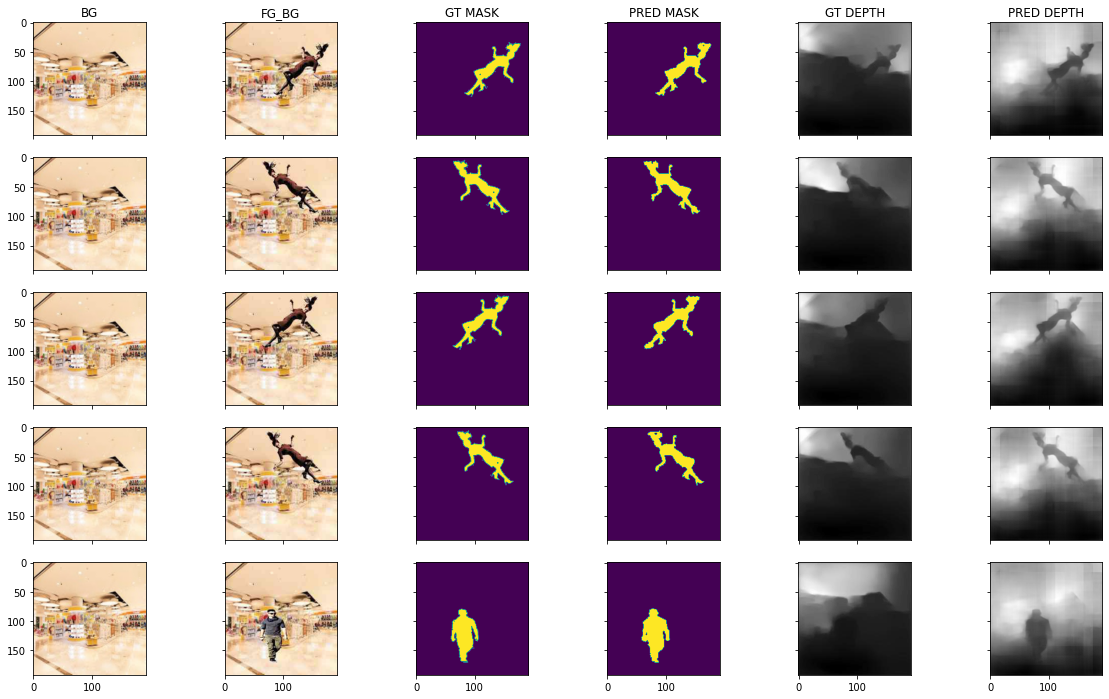

In [26]:
from plot import plot
plot(fgbg, bg, mask_gt,depth_gt, mask_pred, depth_pred)